In [1]:
import numpy as np
import scipy.linalg as la
import scipy.stats as stat
import scipy.optimize as opt
import cmath as comp
import scipy.interpolate as intp
import mat_functions as mat
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import warnings
warnings.filterwarnings("default")

# Introduction to Transfer Matrix Methods

A transfer matrix method (TMM) is a two dimensional optics method that analyzes the propagation of electromagnetic waves through different stratified media. The end results of this calculation give the Fresnel reflection and tranmission coefficients, $r$ and $t$, as well as the intensity of the reflected and tranmitted light, $R$ and $T$ between each thin film. Please see the discussion on Fresnel equations and coefficients below for a clear description of their function and purpose. We can then perform this analysis multiple times for multiple different layers. 


One common use for this computational technique is to model systems of interest in order to determine which parameters give the desired output, without needing to actually create the samples in reality, which can be costly or time-consuming. For example, many optics/nanoplasmonics labs, such as Professor Strangi's lab, are trying to create a material in which the permittivity, $\epsilon_{xyz}$, goes to zero at a desired wavelength. These samples are both time consuming and expensive to fabricate, and finding the configurations within such a massive parameter space by guess-and-check is not feasible. However, wielding the tool that is TMM code, it is easier to test many configurations and only have to fabricate the non-trival ones. The outputs of a TMM code are also illuminating in more complicated physical situations, such as spontaneous emission rate of a dipole in the near field an arbitrary material, which, when done analytically using Green's functions, is actually proportional to the Fresnel coefficent of reflection. Now, we do not intend for our project to go to this great depth, but it is noteworthy that the framework 1. exists and 2. is still extremely useful to an experimentalist. We can also prove the usefulness of the code by creating a material within the constraints of our simulation and measuring its properties to see how the computational result compares to the measurements.

In order to be a useful computational optics tool, a TMM implementation should also be able to work in conjunction with a fitting tool in order to compare to experimental data, and a field amplitude calculator in order to see the field distribution for free without the need for a seperate FD method (this is an added bonus we would like to do, but this is the least necessary). In order to tie in a real application for this method, we plan to show its ability to model/characterize the epsilon-near-zero (ENZ) materials we have previously mentioned, which is non-trivial in its optical effects but has already been characterized.

# ENZ metamaterials:

Optical metamaterials are defined as a structure with a 'unit cell' (as these are generally periodic or just one), is much less than the wavelength of light passing through it. In this regime there is an approximation that can be made called the Effective Medium Theory, which has the same criterion and adds that in this regime the light sees the metamaterial as an an effective medium and can no longer discern the individual unit cell layers. This gives unprecedented power to create materials that have completely exotic optical properties that do not exist in nature. As the name suggusts and ENZ metamaterial takes the dielectric tensor, $\underline{\epsilon}$ (since we're working in 3 dimensional space) and can drive the value of $\epsilon$ at least one of the principle axis of the structure to 0 for some wavelength range. This leads to all sorts of odd behavior, and our focus is the near field ($d<<\lambda$ where $d$ is distance from the structure) enhancement of $\vec{E}$ in that region of space. But at its most basic level the parameters in order to qualify your metamaterial as an ENZ is: 

for a complex dielectric function $\epsilon = \epsilon' + i\epsilon''$ (consider just the axis in which $\epsilon -> 0$) the function must either cross zero or get close enough such that $|\epsilon|^{2} < 0.5$ while minimizing the losses $\epsilon''$ as much as possible, and the difference in phase of the reflected light $\phi_{r}$ to 0 as well within the same wavelenght region. 

There is a lot of extra detail that could be delved into but that is beyond the point that we are trying to make, and that in the field of nanophontonics, there is a huge parameter space to explore to try and meet several criterion, and we've talked about higher dimensional root finding and the inherent difficulty of it. And when fabrication and characterization of samples takes a whole day at least, the need for a computational tool that allows scientists to probe this space more effectively is not just helpful it is absolutely necessary to have in this case. This is a perfect example of where an effective TMM package can shine.

## Theory

Here we will start from Maxwell's equations and get to the Fresnel coefficents and then march on to how the theory of TMM works. 

For all of this, some base assumptions are made:

**1) Linear medium**: we have to assume that we are only dealing with first order effects in the refractive index, if that does not hold this entire derivation (to our knowledge) does not hold anymore, it is not a phenomena that is easy to have happen, nor is it one we wish to probe and as such we are ignoring it entirely.

**2) Homogenous and uniform materials**: when actually creating these thin films there are entire journals written about how materials interact when being deposited at the nanoscale level. Notable effects that cause non-uniformity are; 'bleeding' at interfaces between films, and non-uniformities in the bulk from the deposition method and/or non-stoichiometric materials. Bleeding between interfaces is an effect that our sample creation process have tried to account for and as far as we can tell has been negligible and so it is out of the scope of this project. The same applies for ending with non-stoichiometric materials, for example wanting $Al_{2}O_{3}$ but ending up with some $Al_{2}O_{x}$ which would obviously change the optical properties of the material and overall system, we are actively accounting for this effect now and are going to ignore it. As for bulk defects, once this assumption is lost, the complexity of the problem increases by orders of magnitudes, and so far our lab has corrected/ignored, so we in this project can it too.

**3) non-magnetic materials**: some optics and nanoplasmonic labs care about the value of the permiability, but ours does not, so were going to choose materials where  $\mu \approx \mu_{0}.$ 

Starting with Maxwell's equations and defining the index of refraction as $n = \sqrt{\frac{\epsilon}{\epsilon_{0}}}$, 
$$
\begin{align}
\vec{\triangledown} \cdot \vec{E} &= 0 \\
\vec{\triangledown} \cdot \vec{B} &= 0 \\
\vec{\triangledown} \times \vec{E} &= - \frac{d\vec{B}}{dt} \\
\vec{\triangledown} \times \vec{B} &= \mu \epsilon \frac{d\vec{E}}{dt}
\end{align}
$$
And so for the system described in 'E&M theory,'
from there the electric field can be expressed as a superposition of s and p polarized light, which refers to the direction of the electric field with respect to the plane of incidence. The plane of incidence is the plane that contains the direction of propagation of the incident, reflected, and transmitted wave, with p-polarization referring to the electric field that is parallel and s-polarization referring to the electric field that is perpendicular to the plane of incidence. This superposition looks like,
$$
\begin{align}
\vec{E_i} = (E_{p}^{i} \hat{e_p ^i} + E_{s}^{i} \hat{e_s ^i}) e^{\mathrm{i} \frac{\omega_i}{v_1}(\hat{k_i}\vec{r}-v_1 t)} \\
\vec{E_r} = (E_{p}^{r} \hat{e_p ^r} + E_{s}^{r} \hat{e_s ^r}) e^{\mathrm{i} \frac{\omega_r}{v_1}(\hat{k_r}\vec{r}-v_1 t)} \\
\vec{E_t} = (E_{p}^{t} \hat{e_p ^t} + E_{s}^{t} \hat{e_s ^t}) e^{\mathrm{i} \frac{\omega_t}{v_2}(\hat{k_t}\vec{r}-v_2 t)}.
\end{align}
$$
Maxwell's equations require the continuity of the tangential components of the $\vec{E_i}$ and $\vec{H_i}$ between interfaces to $\vec{E_t}$ and $\vec{H_t}.$ As a consequence of this, Snell's law $n_{i}sin(\theta_{i}) = n_{t}sin(\theta_{t})$ becomes apparent, which allows for the reflected and transmitted field components to be solved for in terms of the incident amplitude, which are the Fresnel equations, these are the amplitude coefficents,
$$
\begin{align}
r_{p} &= E_{p}^{r} &= \frac{B-A}{B+A} E_{p}^{i} \\
r_{s} &= E_{s}^{r} &= \frac{1-AB}{1+AB} E_{s}^{i} \\
t_{p} &= E_{p}^{t} &= \frac{2}{B+A} E_{p}^{i} \\
t_{s} &= E_{s}^{t} &= \frac{2}{1+AB} E_{s}^{i}
\end{align}
$$
Where $A = \frac{cos(\theta_t)}{cos(\theta_i)} = \frac{1}{cos(\theta_i)}\sqrt{1 - (\frac{n_1}{n_2}sin(\theta_i))^2}$ and $B = \frac{n_2}{n_1}.$

We see that these can become complex quantities under certain circumstances. To get the intensities of the Fresnel equations you can simply get them from the amplitudes, as it is the ratios of the power normal to the interface, they are given as,
$$\begin{align}
R_{p,s} &= |r_{p,s}|^{2} \\
T_{p,s} &= \frac{n_{2}cos(\theta_{t})}{n_{1}cos(\theta_{i})}|t_{p,s}|^{2}.
\end{align}$$
Which is just the modulus squared of the amplitude, $T_{p,s}$ contains the factor with the fraction in order to ensure the impedence mismatch and directionality are accounted for from the deffinition of the intensity.

So why is this useful? The whole goal of this is to be able to use this as a computational tool to solve problems in a lab setting, the means to that ends lies in those Fresnel coefficents. The intensities are measureable values which can be measured by an ellipsometer. This gives us a measurable output we can rationalize and compare to real world results as well as do inverse problem solving with $\chi^{2}$ fitting. While the amplitude coefficents are not measurable values, they pop up in the calculations of other quantities, so there exists a stepping stone to numerically model other optical phenomena which may be the actual explorative goal. 

*Ellipsometry:* A measurement device that sends photon at a known wavelength and polarization (either p or s), through or reflected off a sample and then recieves it and measures the change in polarization state. It stores this as a complex value,
$$\rho = \frac{r_{p}}{r_{s}},$$ 
which can show the difference in the amplitude and phase of the ratio, and as such can be written or graphed as,
$$\frac{r_{p}}{r_{s}} = tan(\Psi)\mathrm{e}^{\mathrm{i}\Delta}.$$
Where $\Psi$ is the amplitude ratio and $\Delta$ is the difference in phase. Since this measurement technique only measures a relative difference, extremely precise results can be gained (at the expensive of having no sense of whether the result is physically accurate). Since $r_{p,s}$ are very dependent on the polarization and $n,$ ellipsometry can measure and probe a material's optical properties at a deeply sub-wavelength scale at a high level of precision. From that, models can be used to try and step backwards into a complex 'effective' index of refraction or layer thickness, but that uses a similar modeling system to what is described so it is great in the data it can collect.

# Defining our TMM

Let us consider a stack of $J$ semi-infinite films of arbitrary thickness with an arbitrary cover on top of the stack, and a substrate below the stack. We label our film-film interfaces $0,1,2,...,J.$ We set a right-hand coordinate axis such that the plane of the semi-infinite interfaces is in the yz plane, the plane of incident light is the xy plane, and let $x=0$ at the interface between the cover and our stack.

Our TMM is a generalized version of Snell's law for arbitrary extra materials that accounts for extra reflections in between the layers and gives more information. Consider an EM plane wave with normal incidence on the stack from $x<0$ with a vacuum wavenumber $k$, which can either have transverse magnetic or electric polarization (denoted p or s, respectively, where any arbitrary polarization can be constructed as a linear combination of the two), which can be written as $$\vec{E(\vec{r})}= \vec{E_{0}}*\mathrm{e}^{\mathrm{i}\hat{k}*\vec{r}}$$ where $E_{0}$ is the initial amplitude of the wave. The magnetic field then can be written as $\vec{H(\vec{r})} = \frac{n\vec{E(\vec{r})}}{z_{0}},$ where $n$ is the index of refraction of a non-magnetic material and $z_{0} = \sqrt{\mu_{0}\epsilon_{0}}$ is the impedence of free space. Breaking down the dot product in the exponential reveals two very useful quantities, the direction angles of the wave vector $\alpha$ and $\beta,$ which allows us to write the EM waves' spatial dependence as,
$$
\mathrm{exp}\left[ \mathrm{i}k(\pm\alpha x + \beta y) \right]
$$
This form assumes travel in the positive-y direction, with the positive x-direction to be the positive version version of the equation above. This allows us to define these direction angles as
$$ \begin{align}
\beta &= n\mathrm{sin}(\theta) \\
\alpha &= n\mathrm{cos}(\theta) \\
 &= \sqrt{n^{2} - \beta^{2}}
 \end{align}
$$
What is useful about these quantities is that, as a consequence of Snell's Law and the Law of Reflection, $\beta$ is the same regardless of the medium. These propagation constants are what ensure that Snell's law and the Law of Reflection are obeyed at each interface. This allows us to express EM waves as three non-zero field components, which differ for each polarization state. There is one final polarization-specific coefficent that needs to be defined, $\gamma$, relates the amplitude of the $E$ and $H$ field given as,
$$ \begin{align}
\gamma &= \frac{n\mathrm{cos}(\theta)}{z_{0}} \mathrm{TE} \\
\gamma &= \frac{z_{0}\mathrm{cos}(\theta)}{n} \mathrm{TM}
\end{align}$$
To make this relation polarization independent, the three non-zero field amplitudes are defined as, $W$ the propagation direction, $V$ the parallel plane component, and $W$ the transverse field component. Their relation is given as,
$$\begin{align}
W &= \frac{\beta \gamma}{\alpha}U \\ 
U &= \frac{1}{\mathrm{i}k\gamma \alpha}\frac{\mathrm{d}V}{\mathrm{d}x} \\
V &= \frac{\gamma}{\mathrm{i}k\alpha}\frac{\mathrm{d}U}{\mathrm{d}x}
\end{align}$$
As can be seen $U$ and $V$ are the tangential field components and $W$ is the normal field component. By Maxwell's equations, it is known that the tangential field components are continuous across interfaces and as such an EM plane wave at position $x_{j}$ can be described as a the vector, $$
\begin{pmatrix}
U(x_{j}) \\
V(x_{j})
\end{pmatrix} . $$
These field components also encode the direction of the traveling wave, positive for forward and negative for the reverse direction, and can be expressed as,
$$\begin{align}
\left({\begin{array}{c} U^{+} \\ V^{+}\end{array}}\right) &= \left({\begin{array}{c} 1 \\ \gamma\end{array}}\right)U^{+} \\ 
\left({\begin{array}{c} U^{-} \\ V^{-}\end{array}}\right) &= \left({\begin{array}{c} 1 \\ -\gamma\end{array}}\right)U^{-}
\end{align}$$
If each field component is expressed as a plane wave with complex exponentials, using Euler's identity, a matrix can be constructed that relates the the amplitude of the EM wave at a position $x_{j}$ to a position $x_{j+1}.$ In the form of a simple matrix equation as,
$$ \left( {\begin{array}{c} U_{j-1} \\ V_{j-1}\end{array}} \right)=M_j\left( {\begin{array}{c} U_{j} \\ V_{j}\end{array}} \right)$$

This matrix is called the transfer matrix and is defined as, 
$$
M_{j} = \begin{pmatrix}
cos(\Phi_{j}) & \frac{-\mathrm{i}}{\gamma_{j}}sin(\Phi_{j}) \\
-\mathrm{i}\gamma_{j}sin(\Phi_{j}) & cos(\Phi_{j})
\end{pmatrix} $$
where $\Phi_{j} \equiv k\alpha_{j}(x_{j}-x_{j-1})$ is a phase factor for the $jth$ layer, and $\gamma_{j}$ is a polarization factor for the $jth$ layer. It is easy to see that $\mathrm{Det}(M_{j}) = 1,$ meaning that these transfer matrices are unimodular. And so for a stack of $J$ films the full transfer matrix is the matrix product of all of the individual transfer matrices, 
$$ M = \prod_{j=1}^{J}M_{j} . $$
This method is powerful, since it encodes a lot of information into a simple 2x2 matrix and handles the complexities that would arise if one were to attempt this analytically without this method, such as Snell's Law and Maxwell's Equations. 

The system we have chosen to investigate is one of $J$ thin films of thickness $t_{j}$ with index of refraction $n_{j}$ in a stack where an EM wave either s or p polarized of wavelength $\lambda$ is incident at an angle $\theta$ to the normal, which we define as the x-axis. We are only considering light in the optical regime, which includes wavelengths $300nm < \lambda < 1000nm.$ We are also choosing to consider all incoming angles of incidence such that the incident light can be expressed as plane waves from the positive direction which includes angles $0 < \theta < 90^{o}.$ 

We can then use the outputs of this matrix to deliver the Fresnel coefficients for reflection and transmission and  for both polarizations, as a function of $\lambda$ and/or $\theta,$ as well as the reflectance and transmittance for the same parameters. 

The Fresnel coefficients of reflection and transmission are derived from the relationships found in Maxwell's equations as
$$r=\frac{\gamma_cM_{11}+\gamma_c\gamma_sM_{12}-M_{21}-\gamma_sM_{22}}
{\gamma_cM_{11}+\gamma_c\gamma_sM_{12}+M_{21}+\gamma_sM_{22}}$$
$$t=\frac{2\gamma_c}
{\gamma_cM_{11}+\gamma_c\gamma_sM_{12}+M_{21}+\gamma_sM_{22}}$$
where $\gamma_s$ and $\gamma_c$ are polarization factors for the medium succeeding and preceding the stack, respectively. The reflection and transmission through the stack can be found by using the equations previously defined in the Theory portion, but are now expressed as.
$$\begin{align}
R &= \left| r \right|^{2} \\ 
T &= \frac{\mathrm{Re}(\gamma_{s})}{\mathrm{Re}(\gamma_{c})}\left| t \right|^{2}
\end{align}$$

The formalism of many implementations for TMM seperates the calculation of p-pol and s-pol light, since it is merely a superposition, in order to make the math easier so in the implementation we will adopt this. 

## Implementation


*Fitting Tool:*
This a necessary part of the characterization of optical thin film systems as well as a constant benchmark of how well our computational method captures the physical processes that are occurring for samples that we create. This will take the form of a typical $\chi^2$-esque metric that can be compared to real experimental data taken by an ellipsometer. This would be the output that would be 'optimized,' we can model a system that has some interesting feature in its spectra and then actually go and construct this system and see if our guess was actually correct (assuming we successfully create system within some acceptable deviation). We can also take a sample in which some detail of this system is unknown. For example, let's say the individual thicknesses of the layers (which is a common unknown that is good to know to some degree of accuracy).  We can perform a least-squares fit over the experimental data taken where the only parameters that you are searching for are allowed to vary. This is the beauty of TMM as a computational method, without sacrificing a huge amount of true physicality, it can model rather complicated thin film systems, that would normally require days worth of fabrication and characterization without anything going wrong, with a degree of accuracy that is able to be trusted and be able to guide the design of novel new designs or optimize an existing design to display a highlight a desired phenomena. Additionally, this method is useful to further elucidate an existing sample's properties without having to do any extra measurements. 

*Field Amplitude:* (This is only if we have time to implement, but its also a nice thing to note the TMM can do)

There are several commerical-grade wave modeling systems that allow all sorts of complex optical designs to be built and returns all sorts of metrics such as electric field amplitude as a function of position using (at least generally) advanced PDE solvers. One of the other things that make the version of TMM that we plan to implement so versatile is that for systems, within our allowed parameter space, we can also model the electric field amplitude as a function of position (if we have time). This is not a trivial task (which is why the commercial software exists), but is something that is extremely useful. There are many optical phenomena that require nanometer-scale coupling of the incident EM field (referred to as the near field) with the system structure and/or some sort of radiation dependent object, such as a dye molecule. This ability is useful just like the general TMM and can allow for tailoring of a system to allow for a desired optical phenomena. 

## Snell's Law
We would start trying to test our system. Let's start by showing the difference in the incident and output angle with a simple case of Snell's law from air to glass. 

In [2]:
def snell(n_i,n_f,theta_i):
    '''
    a function that uses snells law to obtain the angle of transmission of a light ray from a material w/ index of refraction n_i, to 
    a material of index of refraction n_f, coming in at an angle of incidence theta_i
    notes:
    tbh idk if this works for more than one wavelength at a time and has no testing in place
    inputs:
    n_i - float (or int if you really feel like it), index of refraction of the incident material
    n_f - float/int, index of refraction of the material the light is propgating into
    theta_i - number (degrees), angle of incidence for the wave 
    outputs:
    theta_f - number (degrees), angle of tranmittance for wave in the new medium
    '''
    theta_f = np.rad2deg(np.arcsin((n_i/n_f)*np.sin(np.deg2rad(theta_i))))
    return theta_f

# Fresnel Equations and Testing
The Fresnel equations tell us about the relative intensities of light of the reflected and transmitted waves with respect to the incident wave, which is helpful for knowing how much relative power is reflected or transmitted. Here we implement these equations for use later with more complex systems, with a few simple test cases including the standard air to glass example, as well as a more exciting air to silver example. We can compare these results with our TMM findings as well as known data to ensure our method functions as intended.

In [3]:
def Fresnel_eqns(n1,n2,theta_i,Ep_i,Es_i):
    #this function takes inputs from the incident wave 
    #and outputs the four fresnel coefficients, which 
    #appear in terms of E^i_p and E^i_s
    #returns one list in the form [Ep_r,Es_r,Ep_t,Es_t]
    
    #n1 and n2 are the indexes of refraction of the given materials
    #mu1 and mu2 are the coefficients of permeability of the given materials
    #theta_i is the angle of incidence of the wave (degrees)
    #Ep_i and Es_i are the incident wave strength coefficients
    #outputs the complex amplitudes of the fields for both polarizations
    wt = np.deg2rad(theta_i) #working theta
    
    A = 1/np.cos(wt)*np.sqrt((1+0j)-(n1/n2*np.sin(wt))**2)
    B = n2/n1
    
    Ep_t = 2/(B+A)*Ep_i
    Ep_r = (B-A)/(B+A)*Ep_i
    Es_t = 2/(1+A*B)*Es_i
    Es_r = (1-A*B)/(1+A*B)*Es_i
    return [Ep_r,Es_r,Ep_t,Es_t]

fresnel_test = Fresnel_eqns(1,1.5,45,5,0)
print(fresnel_test) # testing to make sure its a complex output

[(0.46006681522762183+0j), (-0+0j), (3.6400445434850814+0j), 0j]


Above we encode the Fresnel equations in terms of s and p polarizations of light. The function takes inputs from the incident light and the mediums involved, and then outputs the four Fresnel coefficients in the form of a list $[E^p_r,E^s_r,E^p_t,E^s_t]$ where $E^p$ represents the intensity of p polarized light and $E^s$ represents the intensity of s polarized light, and $E_r$ represents the intensity of the reflected wave, and $E_t$ represents the intensity of the transmitted wave. Typically, s and p polarizations are treated as boolean, where an incident wave is either s or p polarized, but this function allows for an incident wave to be both s and p polarized. We also briefly test the function with an incident p-polarized wave coming from a material with $n = 1$ into a material with $n = 1.5$, both of which have the same coefficients of permeability. 

In [4]:
def r_and_t_coeff(n1,n2,theta_i,Ep_i,Es_i):
    """
    takes system inputs and outputs the reflection and transmission coefficients,
    the default is returning the reflection coefficient first with the output 
    [R,T]
    """
    fresnel = Fresnel_eqns(n1,n2,theta_i,Ep_i,Es_i)
    wt = np.deg2rad(theta_i)
    A = 1/np.cos(wt)*np.sqrt((1+0j)-(n1/n2*np.sin(wt))**2)
    B = n2/n1
    R = (np.abs(fresnel[0])**2 + np.abs(fresnel[1])**2)/(np.abs(Ep_i)**2 + np.abs(Es_i**2))
    T = A*B*((np.abs(fresnel[2])**2 + np.abs(fresnel[3])**2)/(np.abs(Ep_i)**2 + np.abs(Es_i**2)))
    return [R,T.real]
# Put T.real as the output for tranmission as A,B can be complex

## Air to glass/water and glass/water to air
This is a really simple and well-known case, so we know what we want to see. When we have a beam of light incident from air to glass or water, we expect that the beam will reach some maximum angle of refraction because light is bent more from the normal in air than it is in a medium with a higher index of refraction.

When we are going from a higher index of refraction medium to a lower index of refraction medium, the light bends more away from the normal so that it reaches 90 degrees angle of refraction, leading to total internal refraction.

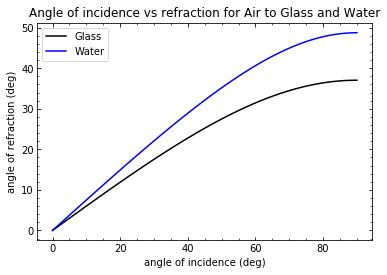

In [5]:
# air to glass/water
n_i = 1. #IOR of air, basically
n_f = np.array([1.66,1.33]) #IOR of glass,water 
theta = np.linspace(0,90,91)
theta_out_glass = snell(n_i,n_f[0],theta)
theta_out_h2o = snell(n_i,n_f[1],theta)
plt.figure();
plt.plot(theta, theta_out_glass,'k',label='Glass');
plt.plot(theta, theta_out_h2o,'b',label='Water');
plt.xlabel("angle of incidence (deg)");
plt.ylabel("angle of refraction (deg)");
plt.legend(loc='best');
plt.title("Angle of incidence vs refraction for Air to Glass and Water");

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in arcsin
  


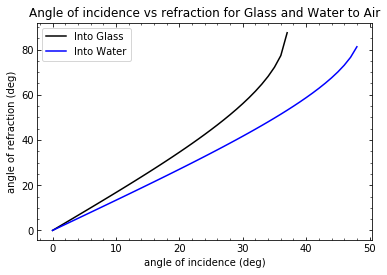

In [6]:
# glass/water to air
th_gl2air = snell(n_f[0],n_i,theta)
th_wt2air = snell(n_f[1],n_i,theta)
plt.figure();
plt.plot(theta,th_gl2air,'k',label='Into Glass');
plt.plot(theta,th_wt2air,'b',label='Into Water');
plt.xlabel("angle of incidence (deg)");
plt.ylabel("angle of refraction (deg)");
plt.legend(loc='best');
plt.title("Angle of incidence vs refraction for Glass and Water to Air");

### Fresnel coefficients for air, water, glass interactions
We also can find the Fresnel coefficients of the same interactions for s and p polarized light and plot these for varying angles of incidence.

In [7]:
# testing r_and_t_coeff for the examples above at lambda = whatever
# air to glass/water
RTp_a2g = r_and_t_coeff(n_i,n_f[0],theta,10.,0.)
RTs_a2g = r_and_t_coeff(n_i,n_f[0],theta,0.,10.)
RTp_a2w = r_and_t_coeff(n_i,n_f[1],theta,10.,0.)
RTs_a2w = r_and_t_coeff(n_i,n_f[1],theta,0.,10.)
# glass/water to air
RTp_g2a = r_and_t_coeff(n_f[0],n_i,theta,10.,0.)
RTs_g2a = r_and_t_coeff(n_f[0],n_i,theta,0.,10.)
RTp_w2a = r_and_t_coeff(n_f[1],n_i,theta,10.,0.)
RTs_w2a = r_and_t_coeff(n_f[1],n_i,theta,0.,10.)
# Fresnel_eqns(n_f[0],n_i,mu,mu,theta,10.,0.)

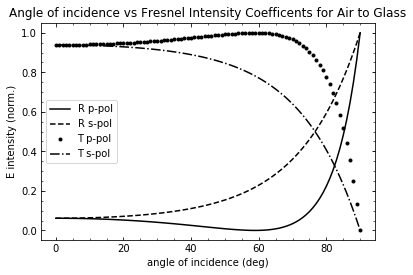

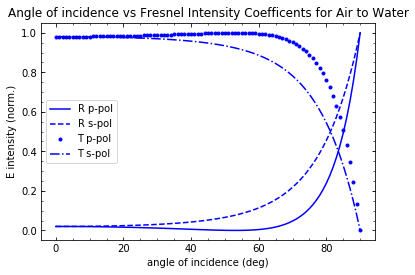

In [8]:
plt.figure();
plt.plot(theta,RTp_a2g[0],'k',label='R p-pol');
plt.plot(theta,RTs_a2g[0],'k--',label='R s-pol');
plt.plot(theta,RTp_a2g[1],'k.',label='T p-pol');
plt.plot(theta,RTs_a2g[1],'k-.',label='T s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.ylabel('E intensity (norm.)');
plt.title('Angle of incidence vs Fresnel Intensity Coefficents for Air to Glass')
plt.figure();
plt.plot(theta,RTp_a2w[0],'b',label='R p-pol');
plt.plot(theta,RTs_a2w[0],'b--',label='R s-pol');
plt.plot(theta,RTp_a2w[1],'b.',label='T p-pol');
plt.plot(theta,RTs_a2w[1],'b-.',label='T s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.ylabel('E intensity (norm.)');
plt.title('Angle of incidence vs Fresnel Intensity Coefficents for Air to Water');

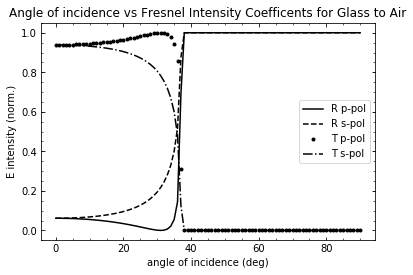

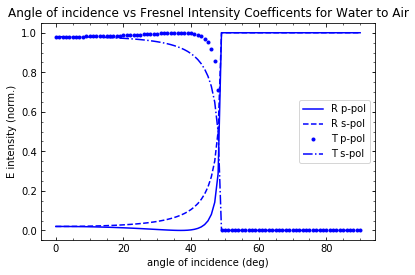

In [9]:
# now we do it the other way around
plt.figure();
plt.plot(theta,RTp_g2a[0],'k',label='R p-pol');
plt.plot(theta,RTs_g2a[0],'k--',label='R s-pol');
plt.plot(theta,RTp_g2a[1],'k.',label='T p-pol');
plt.plot(theta,RTs_g2a[1],'k-.',label='T s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.ylabel('E intensity (norm.)');
plt.title('Angle of incidence vs Fresnel Intensity Coefficents for Glass to Air')
plt.figure();
plt.plot(theta,RTp_w2a[0],'b',label='R p-pol');
plt.plot(theta,RTs_w2a[0],'b--',label='R s-pol');
plt.plot(theta,RTp_w2a[1],'b.',label='T p-pol');
plt.plot(theta,RTs_w2a[1],'b-.',label='T s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.ylabel('E intensity (norm.)');
plt.title('Angle of incidence vs Fresnel Intensity Coefficents for Water to Air');

### Reflection and Transmission coefficients
Finally, we can plot the reflection and transmission coefficients for varying angles of incidence to determine how much of the light is reflected or transmitted. These plots will be more helpful for other test cases, and lays down the groundwork for future tests.

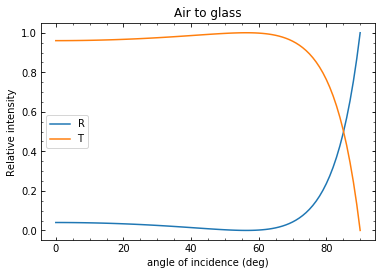

In [10]:
#cell plotting r and t vs angle of incidence for air to glass
theta = np.linspace(0,90,91)

r_simple_airglass = r_and_t_coeff(1,1.5,theta,5,0)[0]
t_simple_airglass = r_and_t_coeff(1,1.5,theta,5,0)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta, r_simple_airglass, label = "R")
ax.plot(theta,t_simple_airglass, label = "T")
ax.set_xlabel("angle of incidence (deg)")
ax.set_ylabel("Relative intensity")
ax.set_title("Air to glass")
ax.legend()

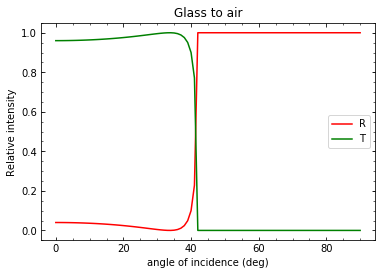

In [11]:
#cell plotting r and t vs angle of incidence for glass to air
r_simple_glassair = r_and_t_coeff(1.5,1,theta,5,0)[0]
t_simple_glassair = r_and_t_coeff(1.5,1,theta,5,0)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta, r_simple_glassair, "r",label = "R")
ax.plot(theta,t_simple_glassair, "g",label = "T")
ax.set_xlabel("angle of incidence (deg)")
ax.set_ylabel("Relative intensity")
ax.set_title("Glass to air")
ax.legend()

In the two cells above, we see an incident wave in air to glass and then an incident wave in glass to air. Let's start with the air to glass plot first (with the blue and orange curves, as opposed to the red and green curves). We see that at low angles of incidence with respect to the normal, the light is mostly transmitted, with only a small portion of the power reflected. Then, as the angle of incidence increases, increasingly more of the light is transmitted until the Brewster angle is reached, which is where all of the light is transmitted and R = 0. After this point, at large angles of incidence, increasingly more of the light is reflected, until finally all of the light is reflected. Let's now turn our attention to the glass to air example. Again, at low angles of incidence, the transmission coefficient is close to 1, until it approaches 1 at the Brewster angle. Then the transmission coefficient begins to steeply drop again, but at some point just above 40 degrees, it cuts off. This is because total internal reflection has occurred, where the transmission coefficient reaches 0, meaning that no light is being transmitted through the medium. Notice that the function does not include wavelengths of incident and transmitted light. For air and glass, these changes in wavelength are relatively straight-forward and not really worth pursuing. The wavelength is proportional to the index of refraction of the material, $n_1 \lambda_1 = n_2 \lambda_2$, so these calculations are really simple for simple materials like air and glass. In fact, we can write a quick function to show how the wavelength changes through materials with different indexes of refraction.

In [12]:
def transmit_lambda(n1,n2,lambda_i):
    #this function outputs the wavelength of light in the transmitted material, in nm
    #make sure your input wavelength is in nm!
    lambda_t = n1/n2*lambda_i
    return lambda_t

#quick example test case, air to glass at 500 nm
print("The wavelength of light inside glass from an incident wave at 500 nm from air is ", transmit_lambda(1,1.5,500)," nm")

The wavelength of light inside glass from an incident wave at 500 nm from air is  333.3333333333333  nm


# Implementation: Transfer Matrix 
Now let's take a look at these behaviors modeled with our TMM method. We use two functions in this case. One to construct the Transfer Matrix and another to gather the fresnel coefficients from that matrix. A small plotting function is also included to make life a little easier due the large number of outputs we create.

In [13]:
def Mj(wavelength,theta,n,dx,Spol):
    """
    function outputs transfer matrix for an individual layer of material
    given the wavenumber, angle of incidence, thickness, and polarization of the light 
    
    Parameters
    ----------
    wavelength:  float [m^-1]
        the wavelength of the incident light
    theta:   float [degrees]
        The angle of incidence of the light on the layer
    n:  float
        the refractive index of the layer J
    dx: float [m]
        the thickness of the layer J
    Spol: boolean
        the polarization of the light
            True:Light is S polarized
            False:Light is P polarized
    Returns
    -------
    Mj:    ndarray
        The transfer matrix for the layer J
    """
    k=2*np.pi/wavelength
    theta=np.deg2rad(theta)
    #Impedence of free space in units of Omega(Ohms)
    z=120*np.pi
    if (Spol==True):
        gamma=n*np.cos(theta)/z
    elif(Spol==False):
        gamma=z*np.cos(theta)/n
    alpha=n*np.cos(theta)
    psi=k*alpha*(dx)
    M=np.array([[np.cos(psi),(-1j*np.sin(psi))/gamma],[-1j*gamma*np.sin(psi),np.cos(psi)]])
    return M

In [14]:
def RT(M,nc,thetac,ns,Spol,full_output=False):
    """
    function outputs transfer matrix for an individual layer of material
    given the wavenumber, angle of incidence, thickness, and polarization of the light 
    
    Parameters
    ----------
    M:    ndarray
        The transfer matrix for the stack of material
    nc:   float
        The index of refraction of the cover
    thetac:   float [degrees]
        The angle of incidence of the light from the cover onto the stack
    ns:   float
        The index of refraction of the substrate
    Spol: boolean
        the polarization of the light
            True:Light is S polarized
            False:Light is P polarized
    full_output:
        If full_output is true it returns the fresnel coefficients r and t
    Returns
    -------
    
    R: float
        Reflection of the incident light
    T: float
        Transmission of the incident light
    r: float(if full_output==True)
        fresnel reflection coefficient
    r: float(if full_output==True)
        fresenel transmission coefficient
    """
    thetac=np.deg2rad(thetac)
    b=nc*np.sin(thetac)
    thetas=np.arcsin(b/ns)
     #Impedence of free space in units of Omega(Ohms)
    z=120*np.pi
    if (Spol==True):
        gammas=ns*np.cos(thetas)/z
        gammac=nc*np.cos(thetac)/z
    elif(Spol==False):
        gammas=z*np.cos(thetas)/ns
        gammac=z*np.cos(thetac)/nc
    rnom=gammac*M[0][0]+gammac*gammas*M[0][1]-M[1][0]-gammas*M[1][1]
    denom=gammac*M[0][0]+gammac*gammas*M[0][1]+M[1][0]+gammas*M[1][1]
    r=rnom/denom
    tnom=2*gammac
    t=tnom/denom
    R=abs(r)**2
    T=(gammas.real/gammac.real)*abs(t)**2
    if (full_output==False):
        return R,T
    elif(full_output==True):
        return R,T,r,t

In [15]:
def plot(theta,R,T,title,xlab='angle of incidence (degrees)'):
    """
    plots the Reflection and Transmission coefficients over a range angles theta (degrees)
    """
    fig = plt.figure();
    ax = fig.add_subplot(111);
    ax.plot(theta,R,label='Reflection')
    ax.plot(theta,T,label='Transmission')
    ax.set_xlabel(xlab)
    ax.set_ylabel('Relative Intensity')
    ax.set_title(title)
    ax.legend()

# Dual Implementations
We had little success to start with, so we went back to the drawing board and decided to do it all again with a new implementation. We tested the two implementations against one another and found agreement between the two and realized that it must just be the models that were wrong. In this new implementation, we construct the transfer matrix just like before, and then we use it to extract the separate Fresnel coefficients explicitly in the cell below that. That way, we have them separate so we can plot them separately for different angles of incidence, different materials, and different wavelengths of incident light, which is helpful to study the behavior of the system in a more in-depth way. Additionally, we define ellipsometry parameters, for which we have data for a lot of these systems.

In [16]:
def field_mat(lam,aoi,n_j,dx,p_pol):
    '''
    given the structure (thickness/index) of the material we would like to study, 
    the incident (vacuum) wavelengths, and the AOI of interest 
    can construct the transfer matrix for the system from the cover (superstrate) through to the substrate
    NOTE: system is defined AND ORDERED as:
    [cover (n_c,inf thickness),j=0] -> [system (nj,xj) for j=1,..,J-1] -> [substrate (n_s,inf thickness,j=J)]
    inputs:
    lam: array, float
        the wavelengths of light (nm) probing the system
    aoi: float
        the angle of incidence of the light (deg)
        NOTE: as of (12/13/19) field_mat CANNOT handle multiple angles at a time, they are handled in the following functions
    nj: matrix (lam,J), complex
        2-D array of index of refraction for system of J layers, including cover and substrate, use material functions
        ex: system is top to bottom [air]->[Al2O3:Ag:Ge]->[glass] then input array([n_c,n_alo,n_ag,n_ge,n_s])
        NOTE: this array must be complex so that the complex numbers show up, either when constructing use:
        np.array([...],dtype=complex) OR after creating use n_j = n_j.astype(complex,copy=False)
    dx: array, float
        vector of the thicknesses of each layer in the system (nm), DONT include the cover/substrate, assumed to be infinite
        same as example above except array doesnt include the first and last elements
    p_pol: boolean, default=True
        returns the transfer matrix for the specified polarization, True gives the p-pol, False gives the s-pol
    outputs:
    M: matrix (lambda,[2x2]),complex
        the transfer matrix for the system that takes you from cover to substrate
    '''
    if (n_j.dtype!='complex128'):
        print('you need to make sure that your array of indices of refraction are complex even if Im(n_j)=0')
        print('go back and try again')
        raise Exception('incorrect data type')
    if (isinstance(aoi,(float))!=True):
        raise Exception('incorrect object class for aoi, please use float')
    z0 = 376.730313667 #impedence of free space, ohms
    k = 2*np.pi/lam #wavenumber
    angle = np.deg2rad(aoi)
    # direction wavevecs
    beta = n_j[:,0]*np.sin(angle)
    # beta is the same in all media so once you have beta from the angle of incidence
    # you can use snells law to get to the incidence angle for all the film-film interfaces
    theta = np.arcsin(beta/n_j.T).T
    alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
    Phi = np.multiply(alpha.T,k).T
    Phi[:,1:-1] *=dx
    # gam is diff for each polarization, so here is where it splits
    if (p_pol==True):
        gam = z0*np.cos(theta)/n_j
    elif (p_pol==False):
        gam = alpha/z0
    else:
        raise Exception('unacceptable input, please input only boolean values')
    M = np.zeros((len(k),2,2))
    M[:] = np.eye(2)
    for i in range(len(n_j[1])):
        mj = np.array([[np.cos(Phi[:,i]),(-1j/gam[:,i])*np.sin(Phi[:,i])],[-1j*gam[:,i]*np.sin(Phi[:,i]),np.cos(Phi[:,i])]])
        mj = np.stack(mj,axis=-1)
        mj = np.stack(mj,axis=-1)
        M = np.matmul(M,mj)
    return M

In [17]:
def crp(lam,aoi,n_j,dx,):
    '''
    given the parameters from 'field_mat' obtain the complex amplitude of reflected light from a system
    aka the reflection fresnel coefficent FOR P-POLARIZATION ONLY
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    crp - array, shape(lam,aoi)
        the complex fresnel reflection coefficent for p-polarized light
    '''
    z0 = 376.730313667 #impedence of free space, ohms
    if (isinstance(aoi,(float,np.ndarray))):
        if (isinstance(aoi,float)):
            # construct field matrix
            M = field_mat(lam,aoi,n_j,dx,p_pol=True)
            # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
            angle = np.deg2rad(aoi) #deg2rad
            beta = n_j[:,0]*np.sin(angle)
            theta = np.arcsin(beta/n_j.T).T
            alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
            # this only returns an array [gam_c,gam_s]
            gam = z0*np.cos(theta)/n_j
            r = np.zeros_like(lam,dtype=complex)
            r = (gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] - M[:,1,0] - gam[:,-1]*M[:,1,1])\
            /(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
        elif (isinstance(aoi,np.ndarray)):
            # now we do the same thing loops over each angle of incidence
            r = np.zeros((len(lam),len(aoi)),dtype=complex)
            for i in range(0,len(aoi)):
                # construct field matrix
                M = field_mat(lam,aoi[i],n_j,dx,p_pol=True)
                # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
                angle = np.deg2rad(aoi[i]) #deg2rad
                beta = n_j[:,0]*np.sin(angle)
                theta = np.arcsin(beta/n_j.T).T
                alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
                # this only returns an array [gam_c,gam_s]
                gam = z0*np.cos(theta)/n_j
                r[:,i] = (gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] - M[:,1,0] - gam[:,-1]*M[:,1,1])\
                /(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
    else:
        raise Exception('incorrect object class for aoi, please use float or array')
    return r
def crs(lam,aoi,n_j,dx):
    '''
    given the parameters from 'field_mat' obtain the complex amplitude of reflected light from a system
    aka the reflection fresnel coefficent FOR S-POLARIZATION ONLY
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    crs - array, shape(lam,aoi)
        the complex fresnel reflection coefficent for s-polarized light
    '''
    z0 = 376.730313667 #impedence of free space, ohms
    if (isinstance(aoi,(float,np.ndarray))):
        if (isinstance(aoi,float)):
            M = field_mat(lam,aoi,n_j,dx,p_pol=False)
            angle = np.deg2rad(aoi)
            beta = n_j[:,0]*np.sin(angle)
            theta = np.arcsin(beta/n_j.T).T
            alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
            gam = alpha/z0
            r = np.zeros_like(lam,dtype=complex)
            r = (gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] - M[:,1,0] - gam[:,-1]*M[:,1,1])\
            /(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
        elif(isinstance(aoi,np.ndarray)):
                        # now we do the same thing loops over each angle of incidence
            r = np.zeros((len(lam),len(aoi)),dtype=complex)
            for i in range(0,len(aoi)):
                # construct field matrix
                M = field_mat(lam,aoi[i],n_j,dx,p_pol=True)
                # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
                angle = np.deg2rad(aoi[i])
                beta = n_j[:,0]*np.sin(aoi[i])
                theta = np.arcsin(beta/n_j.T).T
                alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
                # this only returns an array [gam_c,gam_s]
                gam = alpha/z0
                r[:,i] = (gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] - M[:,1,0] - gam[:,-1]*M[:,1,1])\
                /(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
    else:
        raise Exception('incorrect object class for aoi, please use float or array')
    return r
def ctp(lam,aoi,n_j,dx,):
    '''
    given the parameters from 'field_mat' obtain the complex amplitude of transmitted light from a system
    aka the transmitted fresnel coefficent FOR P-POLARIZATION ONLY
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    trp - array, shape(lam,aoi)
        the complex fresnel reflection coefficent for p-polarized light
    '''
    z0 = 376.730313667 #impedence of free space, ohms
    if (isinstance(aoi,(float,np.ndarray))):
        if (isinstance(aoi,float)):
            # construct field matrix
            M = field_mat(lam,aoi,n_j,dx,p_pol=True)
            # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
            angle = np.deg2rad(aoi)
            beta = n_j[:,0]*np.sin(angle)
            theta = np.arcsin(beta/n_j.T).T
            alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
            gam = z0*np.cos(theta)/n_j
            t = np.zeros_like(lam,dtype=complex)
            t = 2*gam[:,0]/(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
        elif (isinstance(aoi,np.ndarray)):
            # now we do the same thing loops over each angle of incidence
            t = np.zeros((len(lam),len(aoi)),dtype=complex)
            for i in range(0,len(aoi)):
                # construct field matrix
                M = field_mat(lam,aoi[i],n_j,dx,p_pol=True)
                # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
                angle = np.deg2rad(aoi[i])
                beta = n_j[:,0]*np.sin(angle)
                theta = np.arcsin(beta/n_j.T).T
                alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
                gam = z0*np.cos(theta)/n_j
                t[:,i] = 2*gam[:,0]/(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
    else:
        raise Exception('incorrect object class for aoi, please use float or array')
    return t
def cts(lam,aoi,n_j,dx,):
    '''
    given the parameters from 'field_mat' obtain the complex amplitude of transmitted light from a system
    aka the transmitted fresnel coefficent FOR S-POLARIZATION ONLY
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    trs - array, shape(lam,aoi)
        the complex fresnel reflection coefficent for s-polarized light
    '''
    z0 = 376.730313667 #impedence of free space, ohms
    if (isinstance(aoi,(float,np.ndarray))):
        if (isinstance(aoi,float)):
            M = field_mat(lam,aoi,n_j,dx,p_pol=False)
            angle = np.deg2rad(aoi)
            beta = n_j[:,0]*np.sin(angle)
            theta = np.arcsin(beta/n_j.T).T
            alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
            gam = alpha/z0
            t = np.zeros_like(lam,dtype=complex)
            t = 2*gam[:,0]/(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
        elif(isinstance(aoi,np.ndarray)):
                        # now we do the same thing loops over each angle of incidence
            t = np.zeros((len(lam),len(aoi)),dtype=complex)
            for i in range(0,len(aoi)):
                # construct field matrix
                M = field_mat(lam,aoi[i],n_j,dx,p_pol=True)
                # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
                angle = np.deg2rad(aoi[i])
                beta = n_j[:,0]*np.sin(angle)
                theta = np.arcsin(beta/n_j.T).T
                alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
                gam = alpha/z0
                t[:,i] = 2*gam[:,0]/(gam[:,0]*M[:,0,0] + gam[:,0]*gam[:,-1]*M[:,0,1] + M[:,1,0] + gam[:,-1]*M[:,1,1])
    else:
        raise Exception('incorrect object class for aoi, please use float or array')
    return t
def Rp(lam,aoi,n_j,dx):
    '''
    given the parameters from 'field_mat' obtain the intensity of reflected light from a system
    aka the observable reflection intensity for P-polarization
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    R - array, shape(lam,aoi)
        the intensity of the fresnel reflection coefficent for p-polarized light
    '''
    r = crp(lam,aoi,n_j,dx)
    if (r.shape==(len(lam),)):
        R = np.abs(r)**2
#         R = (R-np.min(R))/(np.max(R)-np.min(R))
    else:
        R = np.zeros(r.shape)
        for i in range(0,len(aoi)):
            R[:,i] = np.abs(r[:,i])**2
    return R
def Rs(lam,aoi,n_j,dx):
    '''
    given the parameters from 'field_mat' obtain the intensity of reflected light from a system
    aka the observable reflection intensity for S-polarized light
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    R - array, shape(lam,aoi)
        the intensity of the fresnel reflection coefficent for s-polarized light
    '''
    r = crs(lam,aoi,n_j,dx)
    if (r.shape==(len(lam),)):
        R = np.abs(r)**2
    else:
        R = np.zeros(r.shape)
        for i in range(0,len(aoi)):
            R[:,i] = np.abs(r[:,i])**2
    return R
def Tp(lam,aoi,n_j,dx):
    '''
    given the parameters from 'field_mat' obtain the intensity of transmitted light from a system
    aka the observable tranmission intensity for P-polarization
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    T - array, shape(lam,aoi)
        the intensity of the fresnel transmission coefficent for p-polarized light
    '''
    t = ctp(lam,aoi,n_j,dx)
    if (t.shape==(len(lam),)):
        aoi *= (np.pi/180) #deg2rad
        beta = n_j[:,0]*np.sin(aoi)
        theta = np.arcsin(beta/n_j.T).T
        alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
        gam = z0*np.cos(theta)/n_j
        T = (gam[:,-1].real/gam[:,0].real)*np.abs(t)**2
    else:
        T = np.zeros(t.shape)
        for i in range(0,len(aoi)):
            M = field_mat(lam,aoi[i],n_j,dx,p_pol=True)
            # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
            aoi[i] *= (np.pi/180) #deg2rad
            beta = n_j[:,0]*np.sin(aoi[i])
            theta = np.arcsin(beta/n_j.T).T
            alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
            gam = z0*np.cos(theta)/n_j
            T[:,i] = (gam[:,-1]/gam[:,0])*np.abs(t[:,i])**2
    return T
def Ts(lam,aoi,n_j,dx):
    '''
    given the parameters from 'field_mat' obtain the intensity of transmitted light from a system
    aka the observable tranmission intensity for S-polarization
    inputs:
    lam* - vacuum wavlength of incident light
    aoi - array of floats OR float
        DIFFERENT FROM 'field_mat'. still the angle of incidence but now handles mutiple angles of incidence
    n_j* - refractive indices of system
    dx* - thicknesses of each film in the system
    * = same as field_mat, please see 'field_mat' for how to correctly input information
    outputs:
    T - array, shape(lam,aoi)
        the intensity of the fresnel transmission coefficent for S-polarized light
    '''
    t = cts(lam,aoi,n_j,dx)
    if (t.shape==(len(lam),)):
        aoi *= (np.pi/180) #deg2rad
        beta = n_j[:,0]*np.sin(aoi)
        theta = np.arcsin(beta/n_j.T).T
        alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
        gam = alpha/z0
        T = (gam[:,-1].real/gam[:,0].real)*np.abs(t)**2
    else:
        T = np.zeros(t.shape)
        for i in range(0,len(aoi)):
            M = field_mat(lam,aoi[i],n_j,dx,p_pol=False)
            # r is depenedent on gamma @ the cover and substrate, calc here, same as in field_mat
            aoi[i] *= (np.pi/180) #deg2rad
            beta = n_j[:,0]*np.sin(aoi[i])
            theta = np.arcsin(beta/n_j.T).T
            alpha = np.lib.scimath.sqrt((np.abs(n_j)**2 - np.abs(n_j*np.sin(theta))**2))
            gam = alpha/z0
            T[:,i] = (gam[:,-1]/gam[:,0])*np.abs(t[:,i])**2
    return T
def ellipsometry(crp,crs):
    '''
    an ellipsometer measures the two ellipsometric angles Psi and Delta,
    these come from the complex ratio of rp/rs, which is equal to tan(Psi)*exp[i*Delta]
    this function returns Psi and Delta as a tuple
    inputs:
    crp - array, complex
        the complex amplitude of the reflection fresnel coefficent for p-polarized light
    crs - array, complex
        the complex amplitude of the reflection fresnel coefficent for s-polarized light
    outputs:
    (Psi,Delta) - array, float degrees
        the ellipsometeric angles 
    '''
    if (len(crp.shape)==len(crs.shape)):
        if (len(crp.shape)==1):
            delta = np.angle((crp/crs),deg=True)
            psi = np.arctan(np.abs(crp/crs))*(180/np.pi)
        else:
            psi = delta = np.zeros(crp.shape)
            for i in range(0,len(crp[1])):
                delta[:,i] = np.angle((crp[:,i]/crs[:,i]),deg=True)
                psi[:,i] = np.arctan(np.abs((crp[:,i]/crs[:,i])))*(180/np.pi)
    else:
        raise Exception('crp and crs are not the same shape, please try again')
    return (psi,delta)

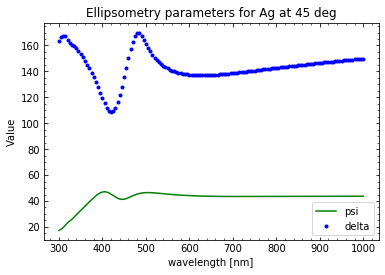

In [18]:
#quick example of plotting ellipsometry parameters for a given material and angle of incidence
lam = np.linspace(300,1000,705//5) #this is either in m or nm 
theta = np.arange(45.,56,5) #deg
aoi = 45. #deg

enz_psi = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/psi_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
enz_del = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/delta_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(lam,enz_psi[0],'g', label = "psi")
ax2.plot(lam,enz_del[0],'b.',label = "delta")
ax2.set_title("Ellipsometry parameters for Ag at 45 deg")
ax2.set_xlabel("wavelength [nm]")
ax2.set_ylabel("Value")
ax2.legend()

## Chi-squared and testing TMM
Beyond visually confirming that our algorithm is able to match the implementation for the simple case, we would like some sort of quantifiable measure of success for our algorithm. Where here we can define a chi^2,$$\chi ^2=\frac{\frac{1}{n}\sum_{x,y}[I_{restored}(x,y)-I(x,y)]^2}{\sigma^2} $$$$ \sigma^2= \frac{1}{n-1}\sum_{x,y}[I(x,y)-I_{mean}]^2$$. This not only allows us to say with concrete evidence how well our implementation does at modeling the behavior of light but we can also use this metric to determine the relationship between different parameters and the success of our algorithm to model real systems. Different parameters could be, thicknesses, indices of refraction, and we can also use this to compare different implementations.
Now that we have a framework for TMM, we can test all this on the same simple cases of air, glass, and water, and test how good our code does with a chi-squared metric. 

Additionally, we can use this chi-squared number later to define a least-squares fit to our ellipsometry parameters in order to find out what the optimal thickness is of our layers, which has physical implications for building and testing a real system.

In [19]:
def chisquared(obs,exp):
    """
    Takes two equally sized N-Dimensional Matrices and performs a normalized 1-Dimensional chi-squared test
    
    Params
    ------
    obs : ndarray
      N-Dimensional matrix of observed values to perform chisquared on
    exp : ndarray
      N-Dimensional matrix of expected values to perform chisquared on
    
    Returns
    -------
    chisquare : float
      The chi-squared value of the matrices
    """
    x2=(obs-exp)**2
    x2 = np.sum(np.sum(x2))/exp.size
    o=stat.tstd(exp,axis=None)+1e-10
    chisquare=x2/o**2/exp.size
    return chisquare


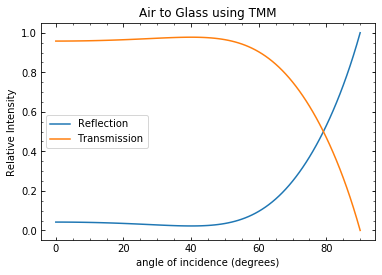

In [20]:
wavelength=587.6*10**(-9)
theta=np.arange(0,91)
n=1.5168
dx=10**(-7)
Spol=True
M=Mj(wavelength,theta,n,dx,Spol)
nc=1
ns=n
R_TMM_airglass,T_TMM_airglass=RT(M,nc,theta,ns,Spol)
plot(theta,R_TMM_airglass,T_TMM_airglass,'Air to Glass using TMM')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in arcsin


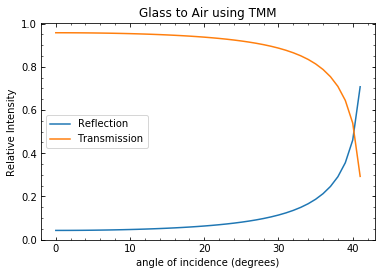

In [21]:
nc=n
ns=1
R_TMM_glassair,T_TMM_glassair=RT(M,nc,theta,ns,Spol)
plot(theta,R_TMM_glassair,T_TMM_glassair,'Glass to Air using TMM')

Looking at the behavior passing through air and glass we get very similar behavior as with the Fresnel coefficents which is a good sign that our model is working. Let's see how good it is with chi-squared testing! We then try to test behavior with complex indices of refraction in the next test case.

In [22]:
#chi-squared testing cell
#first air to glass
chi_r_airglass = chisquared(R_TMM_airglass,r_simple_airglass)
chi_t_airglass = chisquared(T_TMM_airglass,t_simple_airglass)
print("For the simple case of air to glass, the chi-squared test gives us ", chi_r_airglass,"for R, and ",chi_t_airglass,"for T")

For the simple case of air to glass, the chi-squared test gives us  0.004885768118054518 for R, and  0.004885768118054519 for T


In [23]:
#next glass to air
chi_r_glassair = chisquared(R_TMM_glassair[:40],r_simple_glassair[:40])
chi_t_glassair = chisquared(T_TMM_glassair[:40],t_simple_glassair[:40])
print("For the simple case of air to glass, the chi-squared test gives us ", chi_r_glassair,"for R, and ",chi_t_glassair,"for T")

For the simple case of air to glass, the chi-squared test gives us  1.3272604941455242 for R, and  1.3272604941455224 for T


## Data import
Here is a lot of data from Adam's lab for a few systems that we will use later to test against our model. 

In [24]:
# silver data
Ag_delta = np.genfromtxt('./Ag(40nm)-glass(subs)/delta_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
Ag_psi = np.genfromtxt('./Ag(40nm)-glass(subs)/psi_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
Ag_Rp = np.genfromtxt('./Ag(40nm)-glass(subs)/rp_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)
Ag_Rs = np.genfromtxt('./Ag(40nm)-glass(subs)/rs_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)
Ag_Tp = np.genfromtxt('./Ag(40nm)-glass(subs)/tp_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)
# alumina on silicon data, the numbers at the front indicate sample number, they all have varying thicknesses
# that are around 40nm, i figured itd be good for fitting
Al1_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s1_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al1_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s1_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al2_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s2_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al2_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s2_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al3_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s3_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al3_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s3_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al4_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s4_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al4_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s4_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al5_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s5_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al5_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s5_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al6_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s6_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al6_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s6_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al7_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s7_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al7_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s7_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al8_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s8_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al8_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s8_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
# Here is the ENZ, the periodic system
enz_psi = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/psi_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
enz_del = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/delta_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
enz_Rp = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/rp_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
enz_Rs = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/rs_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
enz_Tp = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/tp_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
enz_Ts = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/ts_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
# here is the TiO2 on Ti, they are absorbers, s# is the sample number, and i took data at different spots
# the curves look similar to the graph i sent you in that paper, figure 2
pla1_Rp = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rp_s1_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
pla1_Rs = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rs_s1_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
pla2_delta = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/delta_s2_spot1_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
pla2_psi = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/psi_s2_spot1_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
pla2_Rp = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rp_s2_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
pla2_Rs = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rs_s2_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
pla3_delta = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/delta_s3_spot1_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
pla3_psi = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/psi_s3_spot1_300-5-1000nm_45-5-55deg.txt',usecols=(1,3,5),unpack=True)
pla3_Rp = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rp_s3_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
pla3_Rs = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rs_s3_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)

## Next test Case: Metals with complex indexes of refraction
Now let's see what happens when we try to send a 600 nm wave through a metal like silver. Notice that the index of refraction is complex. This will lead to some differences, so buckle up! Additionally, let's take a look at what the reflection coefficient looks like at different wavelengths for silver.

Text(0.5,1,'Reflection coefficient for Ag at different Wavelengths')

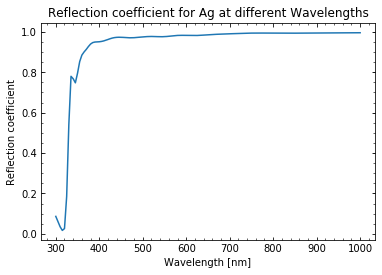

In [25]:
lam = np.linspace(300,1000,705//5) #nm
Nag = mat.Ag(lam)
th0 = 45. #deg
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lam,r_and_t_coeff(1,Nag,th0,10,0)[0])
ax.set_xlabel("Wavelength [nm]")
ax.set_ylabel("Reflection coefficient")
ax.set_title("Reflection coefficient for Ag at different Wavelengths")

In [26]:
print("the index of refraction of Silver at 600 nm is", mat.Ag(600))
RTp_a2ag = r_and_t_coeff(n_i,mat.Ag(600),theta,10.,0.)
RTs_a2ag = r_and_t_coeff(n_i,mat.Ag(600),theta,0.,10.)
RTp_ag2a = r_and_t_coeff(mat.Ag(600),n_i,theta,10.,0.)
RTs_ag2a = r_and_t_coeff(mat.Ag(600),n_i,theta,0.,10.)

the index of refraction of Silver at 600 nm is (0.05418437628333668+4.009387043475303j)


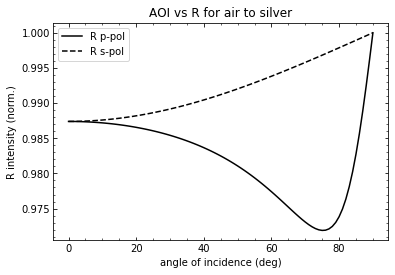

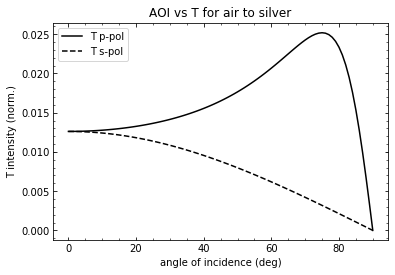

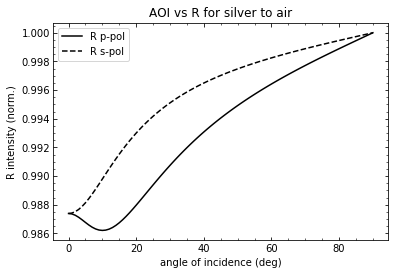

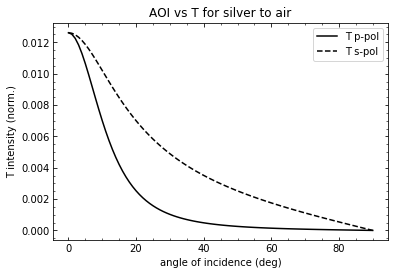

In [27]:
plt.figure();
plt.plot(theta,RTp_a2ag[0],'k',label='R p-pol');
plt.plot(theta,RTs_a2ag[0],'k--',label='R s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.ylabel('R intensity (norm.)');
plt.title('AOI vs R for air to silver')
plt.figure();
plt.plot(theta,RTp_a2ag[1],'k',label='T p-pol');
plt.plot(theta,RTs_a2ag[1],'k--',label='T s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.ylabel('T intensity (norm.)');
plt.title('AOI vs T for air to silver')
plt.figure();
plt.plot(theta,RTp_ag2a[0],'k',label='R p-pol');
plt.plot(theta,RTs_ag2a[0],'k--',label='R s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.ylabel('R intensity (norm.)');
plt.title('AOI vs R for silver to air')
plt.figure();
plt.plot(theta,RTp_ag2a[1],'k',label='T p-pol');
plt.plot(theta,RTs_ag2a[1],'k--',label='T s-pol');
plt.legend(loc='best');
plt.xlabel("angle of incidence (deg)");
plt.title('AOI vs T for silver to air')
plt.ylabel('T intensity (norm.)');

As you know silver is a very reflective metal, and so this is expected as we dont expect much of the incident light to penetrate the system. It does not take a lot of silver to become opticallly thick, even 50nm can do the trick. However, we still see the Brewster angle behavior for P-polarized light.

# Test Case: Reflection and Transmission in metals
## Complex indexes of refraction
The same principles apply for transitions of incident waves to and from metals, they just have weirder indexes of refraction than other materials that we are used to. We can use the functions we developed above to see how light acts in metals. For example, we can test an incident wave from air to silver (which has a complex index of refraction of n = 0.05 + 3.897j at 500 nm), as shown below.

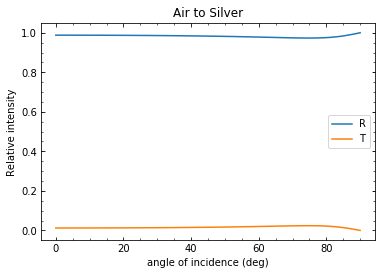

In [28]:
#cell plotting r and t vs angle of incidence for air to silver at 500 nm
theta = np.linspace(0,90,91)

r = r_and_t_coeff(1,0.05+3.897j,theta,5,0)[0]
t = r_and_t_coeff(1,0.05+3.897j,theta,5,0)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta, r, label = "R")
ax.plot(theta,t, label = "T")
ax.set_xlabel("angle of incidence (deg)")
ax.set_ylabel("Relative intensity")
ax.set_title("Air to Silver")
ax.legend()

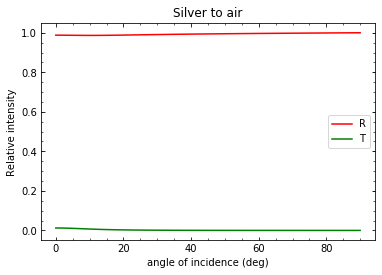

In [29]:
#cell plotting r and t vs angle of incidence for silver to air
r = r_and_t_coeff(0.05+3.897j,1,theta,5,0)[0]
t = r_and_t_coeff(0.05+3.897j,1,theta,5,0)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta, r, "r",label = "R")
ax.plot(theta,t, "g",label = "T")
ax.set_xlabel("angle of incidence (deg)")
ax.set_ylabel("Relative intensity")
ax.set_title("Silver to air")
ax.legend()

This is some pretty funky behavior, but we see that we have to include the complex index of refraction, because if we didn't, it would change the output substantially. Here is the difference, which is wrong! 

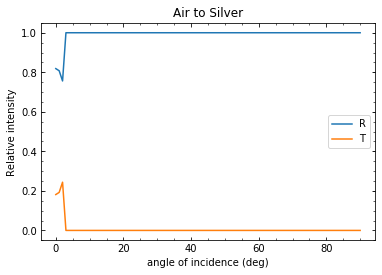

In [30]:
#cell plotting r and t vs angle of incidence for air to silver at 500 nm, with only real part 
theta = np.linspace(0,90,91)

r = r_and_t_coeff(1,0.05,theta,5,0)[0]
t = r_and_t_coeff(1,0.05,theta,5,0)[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(theta, r, label = "R")
ax.plot(theta,t, label = "T")
ax.set_xlabel("angle of incidence (deg)")
ax.set_ylabel("Relative intensity")
ax.set_title("Air to Silver")
ax.legend()

## TMM vs Complex index of refraction
Now we can apply our TMM code to the metal with complex index of refraction.

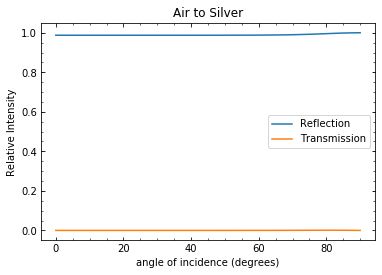

In [31]:
wavelength=587.6*10**(-9)
theta=np.arange(0,91)
n=0.051585+3.9046j
dx=10**(-7)
M=Mj(wavelength,theta,n,dx,Spol)
nc=1
ns=n
R,T=RT(M,nc,theta,ns,Spol)
plot(theta,R,T,'Air to Silver')

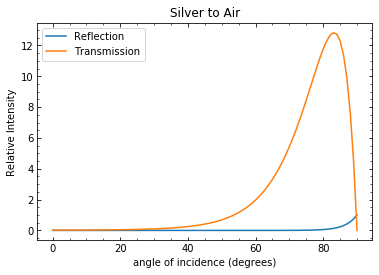

In [32]:
nc=n
ns=1
R,T=RT(M,nc,theta,ns,Spol)
plot(theta,R,T,'Silver to Air')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in arcsin


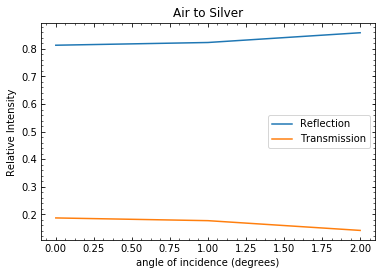

In [33]:
wavelength=587.6*10**(-9)
theta=np.arange(0,91)
n=0.051585
dx=10**(-7)
M=Mj(wavelength,theta,n,dx,Spol)
nc=1
ns=n
R,T=RT(M,nc,theta,ns,Spol)
plot(theta,R,T,'Air to Silver')

The implementation stops short here because it doesn't know how to deal with a negative sign under the radical, so it treats it as not a number, and stops it after only two degrees.

Here we see a lot of disagreement between the two models. This is partly because the TMM code is better at handling complex numbers compared the Fresnel coefficient code, but we see some additional and inexplicable disagreement in general. Even only using the real index of refraction of silver we end up with some disagreement. In the final phase we hope to fix these differences before proceeding with our TMM model.

# MultiLayer Systems

Here are some basic implementations of multilayer systems. The top is very simple and not very efficient but shows the Relative Intensity of a multilayer waveguide and different angles. 

In [34]:
def Mtot(k,theta,n,dx,Spol):
    """
    sums all arrays Mj for each layer
    """
    M=Mj(k,theta,n[0],dx[0],Spol)
    assert(dx.size==n.size)
    for j in range (dx.size):  
        M2=Mj(k,theta,n[j],dx[j],Spol)
        for i in range (theta.size):
            M[:,:,i]=M[:,:,i]@M2[:,:,i]
    return M

In [35]:
#Dumb way around problem I'm having
def Mf(w,theta,n,dx,Spol):
    Mf=np.zeros((w.size,2,2,theta.size),dtype=complex)
    for k in range (w.size):
        Mf[k]=Mtot(w[k],theta,n[k],dx,Spol)
    return Mf

## Test Case Systems Calculations
In the following cell, we define some test cases which we will dive into more a little later. Here is just a good place to store all the information.


In [36]:
# testing cell
lam = np.linspace(300,1000,705//5) #this is either in m or nm 
theta = np.arange(45.,56,5) #deg
aoi = 45. #deg
# system 1: [air,Ag(40nm),glass substrate]
ntst_ag = np.zeros((len(lam),3),dtype=complex)
ntst_ag[:,0] = 1.
ntst_ag[:,1] = mat.Ag(lam)
ntst_ag[:,2] = mat.Glass_sub(lam)
#either m or nm
dx_ag = np.array([40.])
# system 2: alumina testing [air,Al2O3(~40nm),Si substrate]
ntst_al = np.zeros((len(lam),3),dtype=complex)
ntst_al[:,0] = 1.
ntst_al[:,1] = mat.Al2O3(lam)
ntst_al[:,2] = mat.Si_sub(lam)
dx_al = np.array([40.])
# sys 3: Ti, low grade reflector R~.5 [air,Ti(150nm),glass or Si (shouldnt matter)]
ntst_ti = np.zeros((len(lam),3),dtype=complex)
ntst_ti[:,0] = 1.
ntst_ti[:,1] = mat.Ti(lam)
ntst_ti[:,2] = mat.Glass_sub(lam)
dx_ti = np.array([150.])
# ntst_ti[:,2] = mat.Si_sub(lam) either one should give the same results
# sys 4: ENZ ~550nm [air,{Al2O3(40nm),Ag(8nm),Ge(.5nm,hopefully doesnt matter)}x5,glass]
ntst_enz = np.zeros((len(lam),17),dtype=complex)
dx_enz = np.zeros(15)
ntst_enz[:,0] = 1.
for i in range(len(lam)):
    ntst_enz[i,1:-1:3] = mat.Al2O3(lam)[i]
    ntst_enz[i,2:-1:3] = mat.Ag(lam)[i]
    ntst_enz[i,3:-1:3] = mat.Ge(lam)[i]
ntst_enz[:,-1] = mat.Glass_sub(lam)
dx_enz[::3] = 40.
dx_enz[1::3] = 8.
dx_enz[2::3] = .5 #may be able to get rid off
# sys 5: josh's waveguide (do aoi vs R,T) [air,glass(100nm),silver(10nm),glass(100nm),air]
th_wvg = np.arange(1.,91)
# unsure what wavelength to use, so ive done 500nm
nwvg = np.zeros(5,dtype=complex)
nwvg[0::4] = 1.
nwvg[1::2] = mat.Glass_sub(500.)
nwvg[2] = mat.Ag(500.)

# Test Case: Silver and Glass Substrate
Let's start with the silver and glass substrate test case. Physically, this system will have air, then 40 nm of Silver, then finally the glass substrate. For this system, we have Rp and Rs and Tp, as well as the ellipsometry parameters, so we are able to check this one against the data to find out how well our model does for this system. 

Text(0,0.5,'Rs')

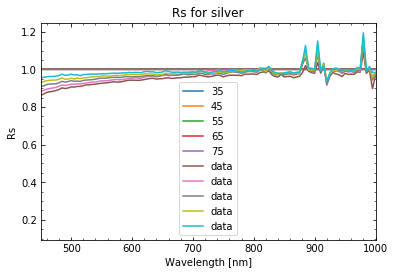

In [37]:
Ag_Rp = np.genfromtxt('./Ag(40nm)-glass(subs)/rp_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)
Ag_Rs = np.genfromtxt('./Ag(40nm)-glass(subs)/rs_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)

lam = np.linspace(300,1000,705//5) #this is either in m or nm 
theta = np.arange(45.,56,5) #deg
aoi = 45. #deg
th = np.array([35.,45,55,65,75])
ntst_ag = np.zeros((len(lam),3),dtype=complex)
ntst_ag[:,0] = 1.
ntst_ag[:,1] = mat.Ag(lam)
ntst_ag[:,2] = mat.Glass_sub(lam)

Rs_ag = Rs(lam,th,ntst_ag,dx_ag)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(lam,Rs_ag[:,0],label='35')
ax2.plot(lam,Rs_ag[:,1],label='45')
ax2.plot(lam,Rs_ag[:,2],label='55')
ax2.plot(lam,Rs_ag[:,3],label='65')
ax2.plot(lam,Rs_ag[:,4],label='75')
ax2.plot(lam,Ag_Rs.T,label = "data")
plt.xlim(450,1000)
ax2.legend(loc='best')
ax2.set_title("Rs for silver")
ax2.set_xlabel("Wavelength [nm]")
ax2.set_ylabel("Rs")

We can see that our system does pretty well for the Rs for various wavelengths. It doesn't really do the best, but also this hints at the physical limitations of our model. 

## Aside: Physics of Noble Metals
One of great discoveries of in the field of optics was nanophotonics and nanoplasmonics, which is the study of plasmonics. A plasmon is akin to a phonon however, instead of an oscilating atom, it is a transverse wave of oscilating electrons in the eletron sea of metals. It can be excited optically but is deeply subwavelength and decays within a micrometer. It has been extensively studied as a possible method of breaking the diffraction limit as it does carry the information from the light that excites it. The important information from this aside is that this phenomeon can only be excited with P-polarized light around ~300nm. However the model we use for silver breaks down in this regime, and a model that can capture this physics is far more complicated than the scope of this project. So unfortunately there is a gap in what we can correctly model. 

# New Test Case: Air, Glass, Silver, Glass
Next, we can define a test case manually with the materials listed above. Here, we hard code our own indexes of refraction into the array that stores those values. We have data for this system as well, so we can also check it against the model we have built in order to test how well our model is performing. Again, we see some discrepancy between our model and the data that has been produced. 

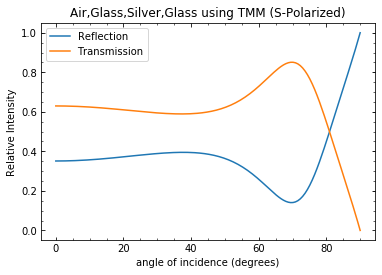

In [38]:
#my test case
w=np.array([587.6,587.6])*1e-9
theta=np.linspace(0,90,2**7)
n=np.array([[1.5168,0.051585+3.9046j,1.5168],[1.5168,0.051585+3.9046j,1.5168]])
dx=np.array([1e-7,1e-8,1e-7])
Spol=True
M=Mf(w,theta,n,dx,Spol)
nc=1
ns=n[0,-1]
R_TMM_airglass,T_TMM_airglass=RT(M[1],nc,theta,ns,Spol)
plot(theta,R_TMM_airglass,T_TMM_airglass,'Air,Glass,Silver,Glass using TMM (S-Polarized)')

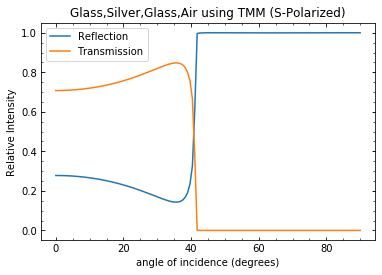

In [39]:
nc=n[0,-1]
ns=1
R_TMM_glassair,T_TMM_glassair=RT(M[0],nc,theta,ns,Spol)
plot(theta,R_TMM_glassair,T_TMM_glassair,'Glass,Silver,Glass,Air using TMM (S-Polarized)')

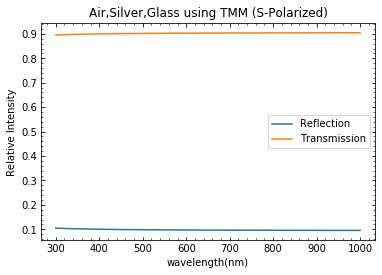

In [40]:
lam = np.linspace(300,1000,705//5) #this is either in m or nm 
theta = np.linspace(0,90,91) 
aoi = 45 #deg
# system 1: [air,Ag(40nm),glass substrate]
ntst_ag = np.zeros((len(lam),3),dtype=complex)
ntst_ag[:,0] = 1.
ntst_ag[:,1] = mat.Ag(lam)
ntst_ag[:,2] = mat.Glass_sub(lam)
dx=np.array([100,40,100])*1e-9
Spol=True
M=Mf(lam,theta,ntst_ag,dx,Spol)
nc=ntst_ag[:,0]
ns=ntst_ag[:,-1]
R_TMM,T_TMM=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
plot(lam,R_TMM,T_TMM,'Air,Silver,Glass using TMM (S-Polarized)','wavelength(nm)')

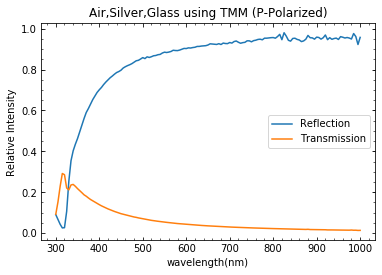

In [41]:
Ag_rp = np.genfromtxt('./Ag(40nm)-glass(subs)/rp_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)
Ag_rs = np.genfromtxt('./Ag(40nm)-glass(subs)/rs_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)
Ag_tp = np.genfromtxt('./Ag(40nm)-glass(subs)/tp_300-5-1000nm_35-10-75deg.txt',usecols=(1,3,5,7,9),unpack=True)
plot(lam,Ag_rp[1],Ag_tp[1],'Air,Silver,Glass using TMM (P-Polarized)','wavelength(nm)')

# New Test Case: Air, Aluminum, Silicon
Next, we can define a test case manually with the materials listed above. This time, we take our indexes of refraction from data tables that we have imported, where it is notable that the indexes of refraction change as a function of the incident wavelength of light. We have data for this system as well, so we can also check it against the model we have built in order to test how well our model is performing. Again, we see some discrepancy between our model and the data that has been produced.

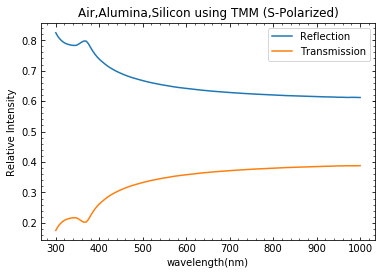

In [42]:
lam = np.linspace(300,1000,705//5) #this is either in m or nm 
theta = np.linspace(0,90,91) 
aoi = 65 #deg
# system 2: alumina testing [air,Al2O3(~40nm),Si substrate]
ntst_al = np.zeros((len(lam),3),dtype=complex)
ntst_al[:,0] = 1.
ntst_al[:,1] = mat.Al2O3(lam)
ntst_al[:,2] = mat.Si_sub(lam)
dx=np.array([100,40,100])*1e-9
Spol=True
M=Mf(lam,theta,ntst_al,dx,Spol)
nc=ntst_al[:,0]
ns=ntst_al[:,-1]
R_TMM,T_TMM=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
plot(lam,R_TMM,T_TMM,'Air,Alumina,Silicon using TMM (S-Polarized)','wavelength(nm)')

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


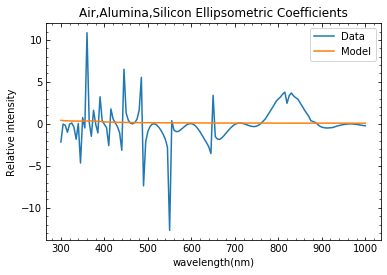

In [43]:
def Ellip(psi,delta):
    return np.tan(psi)*np.exp(1j*delta)
Al1_delta = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s1_delta_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
Al1_psi = np.genfromtxt('./Al2O3(40nm)_Si(substrate)/s1_psi_300-5-1000nm_65-5-75deg.txt',usecols=(1,3,5),unpack=True)
rho=Ellip(Al1_psi,Al1_delta)
Spol=True
M=Mf(lam,theta,ntst_al,dx,Spol)
nc=ntst_al[:,0]
ns=ntst_al[:,-1]
R_TMMs,T_TMMs=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
Spol=False
M=Mf(lam,theta,ntst_al,dx,Spol)
nc=ntst_al[:,0]
ns=ntst_al[:,-1]
R_TMMp,T_TMMp=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(lam, rho[0],label = "Data")
ax.plot(lam,R_TMMp/R_TMMs,label = "Model")
ax.set_xlabel('wavelength(nm)')
ax.set_ylabel("Relative intensity")
ax.set_title('Air,Alumina,Silicon Ellipsometric Coefficients')
ax.legend()

This one actually shows some decent agreement between model and data! The huge spikes are a little concerning, but on average, the behavior matches what we predict.

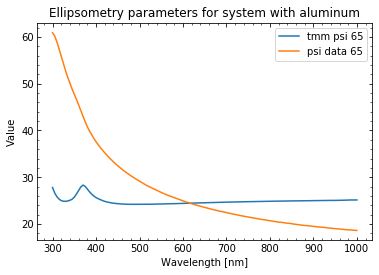

In [44]:
(psi_al,del_al) = ellipsometry(crp(lam,th,ntst_al,dx_al),crs(lam,th,ntst_al,dx_al))
#print(psi_al,del_al)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(lam,psi_al[:,0],label='tmm psi 65')
#ax.plot(lam,del_al[:,0], label = 'tmm del 65')
#ax.plot(lam,Al1_delta[0].T, label = "delta data 65")
ax.plot(lam,Al1_psi[0].T, label = "psi data 65")
ax.set_title("Ellipsometry parameters for system with aluminum")
ax.set_ylabel("Value")
ax.set_xlabel("Wavelength [nm]")
ax.legend(loc='best')

# New Test Case: Air, Titanium oxide, Titanium, Glass
Next, we can define a test case manually with the materials listed above. Once again, we take our indexes of refraction from data tables where the index of refraction changes as a function of incident wavelength. We have data for this system as well, so we can also check it against the model we have built in order to test how well our model is performing. Again, we see some discrepancy between our model and the data that has been produced.

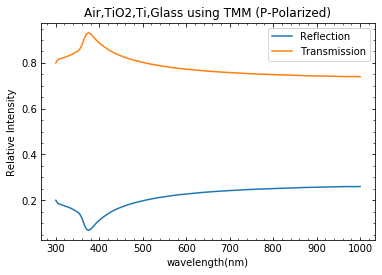

In [45]:
lam = np.linspace(300,1000,705//5) #this is either in m or nm 
theta = np.linspace(0,90,91) 
aoi = 85 #deg
# sys 3: TiO2,Ti, low grade reflector R~.5 [air,Ti(150nm),glass or Si (shouldnt matter)]
ntst_ti = np.zeros((len(lam),2),dtype=complex)
ntst_ti[:,0] = mat.TiO2(lam)
ntst_ti[:,1] = mat.Ti(lam)
dx=np.array([20,150])*1e-9
Spol=False
M=Mf(lam,theta,ntst_ti,dx,Spol)
nc=1
ns=mat.Si_sub(lam)
R_TMM,T_TMM=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
plot(lam,R_TMM,T_TMM,'Air,TiO2,Ti,Glass using TMM (P-Polarized)','wavelength(nm)')

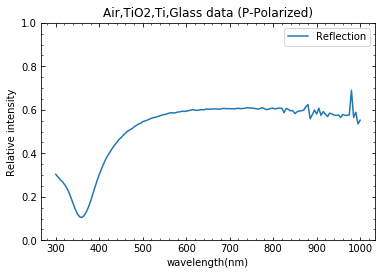

In [46]:
pla1_rp = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rp_s1_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
pla1_rs = np.genfromtxt('./TiO2-Ti(150nm)-si(substrate)/rs_s1_spot1_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(lam, pla1_rp[7],label = "Reflection")
ax.set_ylim([0,1])
ax.set_xlabel('wavelength(nm)')
ax.set_ylabel("Relative intensity")
ax.set_title('Air,TiO2,Ti,Glass data (P-Polarized)')
ax.legend()

In [47]:
def TMM(lam,theta,ntst,dx,Spol):
    M=Mf(lam,theta,ntst,dx,Spol)
    nc=ntst[:,0]
    ns=ntst[:,-1]
    R_TMM,T_TMM=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
    return R_TMM

In [48]:
def optimal2(dx,theta,ntst,lam,Spol,data):
        obs=TMM(lam,theta,ntst,dx,Spol)
        exp=data
        return chisquared(obs,exp)

In [49]:
dx=np.array([20,150])*1e-9
bnds = ((0, None), (0, None))
result=opt.minimize(optimal2,dx,args=(theta,ntst_ti,lam,Spol,pla1_rp),bounds=bnds,options={'disp':True})

In [50]:
result

      fun: 0.0008664541011412672
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.13201852e-06, -9.86781186e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 5
   status: 0
  success: True
        x: array([ 2.35612671, 33.72286274])

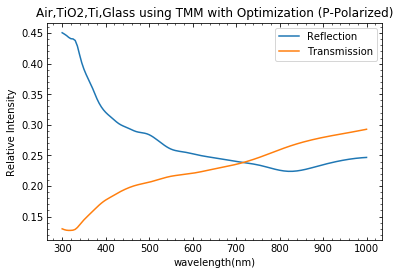

In [51]:
dx=result.x
M=Mf(lam,theta,ntst_ti,dx,Spol)
nc=ntst_ti[:,0]
ns=ntst_ti[:,-1]
R_TMM,T_TMM=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
plot(lam,R_TMM,T_TMM,'Air,TiO2,Ti,Glass using TMM with Optimization (P-Polarized)','wavelength(nm)')

This is another system which we could not capture. It is a novel perfect light absorber that our lab fabricated last year. The dip in reflection is qualitatively correct however, reflectance everywhere but dip shoul be higher and the transmission should be much lower. The curve fitting also works extraordinarily poorly but if we had more time we could improve upon this. 

# New Test Case: ENZ materials

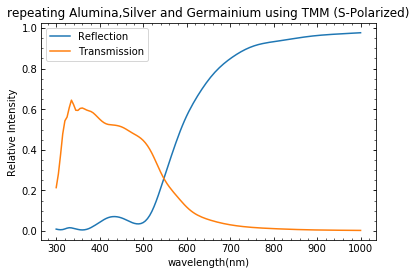

In [52]:
#testing against the mew model as well

lam = np.linspace(300,1000,705//5) #this is either in m or nm 
theta = np.linspace(0,90,91) 
aoi = 15 #deg
# sys 4: ENZ ~550nm [air,{Al2O3(40nm),Ag(8nm),Ge(.5nm,hopefully doesnt matter)}x5,glass]
ntst_enz = np.zeros((len(lam),15),dtype=complex)
dx_enz = np.zeros(15)
ntst_enz[:,0] = 1.
for i in range(len(lam)):
    ntst_enz[i,::3] = mat.Al2O3(lam)[i]
    ntst_enz[i,1::3] = mat.Ag(lam)[i]
    ntst_enz[i,2::3] = mat.Ge(lam)[i]
ntst_enz[:,-1] = mat.Glass_sub(lam)
dx_enz[::3] = 40.
dx_enz[1::3] = 8.
dx_enz[2::3] = .5 #may be able to get rid off
dx=dx_enz
Spol=True
Ppol=False
M=Mf(lam,theta,ntst_enz,dx,Spol)
nc=ntst_enz[:,0]
ns=ntst_enz[:,-1]
R_TMM,T_TMM=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
plot(lam,R_TMM,T_TMM,'repeating Alumina,Silver and Germainium using TMM (S-Polarized)','wavelength(nm)')

Here is the data for epsilon near zero (ENZ) materials. We can test this against what we get from our models.

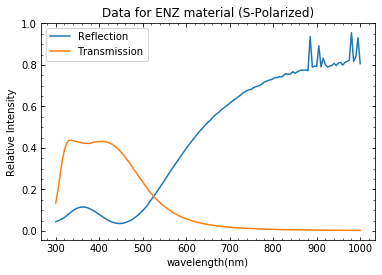

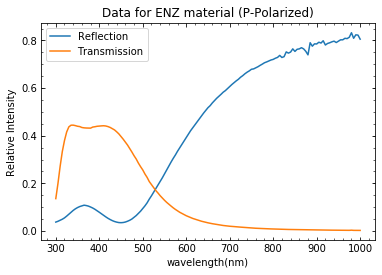

In [53]:
enz_rp = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/rp_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
enz_rs = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/rs_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
enz_tp = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/tp_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
enz_ts = np.genfromtxt('./Al2O3(40nm)-Ag(8nm)-Ge(1nm)x5-data/ts_300-5-1000nm_15-10-85deg.txt',usecols=(1,3,5,7,9,11,13,15),unpack=True)
plot(lam,enz_rs[0],enz_ts[0],'Data for ENZ material (S-Polarized)','wavelength(nm)')
plot(lam,enz_rp[0],enz_tp[0],'Data for ENZ material (P-Polarized)','wavelength(nm)')

# Attempt at curve fitting
We discussed earlier that fitting for thickness of layers is possible using optimizing over the ellipsometry parameters, so we try that here...it doesn't go too well. In practice, we are trying to fit over a really large amount of parameters, so to keep the system simple, we keep a lot of parameters constant and try to fit over the remaining three. If we had more time, we could design a better optimization strategy with more parameters that works better.

In [54]:
def optimal(dx,theta,ntst,lam,Spol,data):
        ddx=np.zeros(15)
        ddx[::3]=dx[0]
        ddx[1::3]=dx[1]
        ddx[2::3]=dx[2]
        obs=TMM(lam,theta,ntst,ddx,Spol)
        exp=data
        return chisquared(obs,exp)


In [55]:
dx=np.array([40,8,.5])
result=opt.minimize(optimal,dx,args=(theta,ntst_enz,lam,Spol,enz_rs),options={'disp':True})

Optimization terminated successfully.
         Current function value: 0.000226
         Iterations: 26
         Function evaluations: 170
         Gradient evaluations: 34


In [56]:
dx=result.x
ddx=np.zeros(15)
ddx[::3]=dx[0]
ddx[1::3]=dx[1]
ddx[2::3]=dx[2]

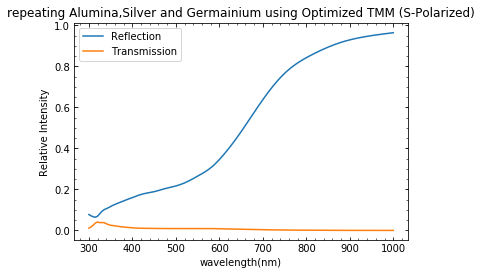

In [57]:
M=Mf(lam,theta,ntst_enz,ddx,Spol)
nc=ntst_enz[:,0]
ns=ntst_enz[:,-1]
R_TMM,T_TMM=RT(np.transpose(M[:,:,:,aoi],(1,2,0)),nc,aoi,ns,Spol)
plot(lam,R_TMM,T_TMM,'repeating Alumina,Silver and Germainium using Optimized TMM (S-Polarized)','wavelength(nm)')

Text(0.5,0,'Wavelength')

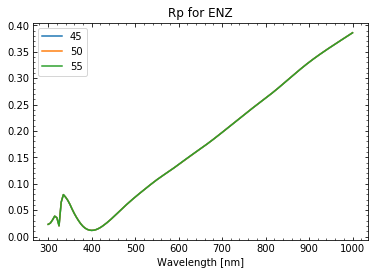

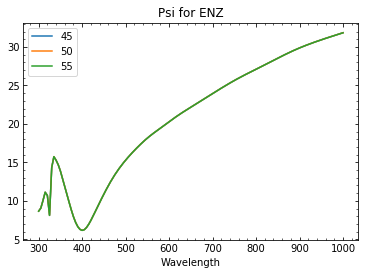

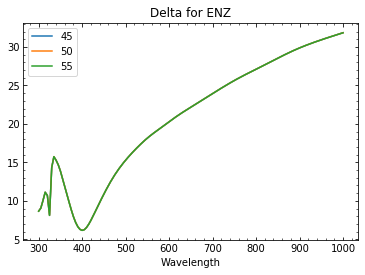

In [58]:
# sys 4: ENZ ~550nm [air,{Al2O3(40nm),Ag(8nm),Ge(.5nm,hopefully doesnt matter)}x5,glass]
ntst_enz = np.zeros((len(lam),17),dtype=complex)
dx_enz = np.zeros(15)
ntst_enz[:,0] = 1.
for i in range(len(lam)):
    ntst_enz[i,1:-1:3] = mat.Al2O3(lam)[i]
    ntst_enz[i,2:-1:3] = mat.Ag(lam)[i]
    ntst_enz[i,3:-1:3] = mat.Ge(lam)[i]
ntst_enz[:,-1] = mat.Glass_sub(lam)
dx_enz[::3] = 40.
dx_enz[1::3] = 8.
dx_enz[2::3] = .5 #may be able to get rid off

Rp_enz = Rp(lam,theta,ntst_enz,dx_enz)
(psi_enz,delta_enz) = ellipsometry(crp(lam,theta,ntst_enz,dx_enz),crs(lam,theta,ntst_enz,dx_enz))
plt.figure();
plt.plot(lam,Rp_enz[:,0],label='45');
plt.plot(lam,Rp_enz[:,1],label='50');
plt.plot(lam,Rp_enz[:,2],label='55');
plt.title("Rp for ENZ")
plt.xlabel("Wavelength [nm]")
plt.legend(loc='best');
plt.figure();
plt.plot(lam,psi_enz[:,0],label='45');
plt.plot(lam,psi_enz[:,1],label='50');
plt.plot(lam,psi_enz[:,2],label='55');
plt.legend(loc='best');
plt.title("Psi for ENZ")
plt.xlabel("Wavelength")
plt.figure();
plt.plot(lam,delta_enz[:,0],label='45');
plt.plot(lam,delta_enz[:,1],label='50');
plt.plot(lam,delta_enz[:,2],label='55');
plt.legend(loc='best');
plt.title("Delta for ENZ")
plt.xlabel("Wavelength")